# Geographical and Practice Data

Below we take the two csv files as well as relevant number of patients registered at each GP Surgery (dropping GP specific data) so we can then help PHE assess the per capita variations in cost between these time frames for each surgery as well as painting a broader picture of the needs of Manchester for prescriptions by costs and identifying potential areas of investigation to enable better financial management. We need parse the postcode and repeat the process and finally using GeoJson allow us to visualise these differences. Finally, to enable more broad capacity needs assessment we repeat this procedure on total cost. I have also added an optional cell to enable a deeper dive into domain specific prescription type needs.   

## Set up, Data loading
importing pandas for dataset manipulation, matplotlib for non-geographical visualations, requests to pull geojson from github, plotly for geographical (interactive) visualisations and use plotly.io to enable us to push these to browser 

In [16]:
##Initial Set Up

!pip install pandas
!pip install matplotlib
!pip install requests
!pip install "notebook>=5.3" "ipywidgets>=7.5"
!pip install plotly

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import requests
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'browser'

## Import Data
Including Perscription data for Manchester (April 2020 & April 2021), GP registered patients (April 2020 & April 2021) and a GeoJSON mapping Manchester 

In [59]:
M2020 = pd.read_csv (r'C:\Users\nickw\OneDrive\Documents\Python Scripts\Test\Test\EPD_202004.csv')

M2021 = pd.read_csv (r'C:\Users\nickw\OneDrive\Documents\Python Scripts\Test\Test\EPD_202104.csv')

##Import Population Data by Practice

pop_gp_2020 = pd.read_csv (r'C:\Users\nickw\OneDrive\Documents\Python Scripts\Test\Test\gp_pop.csv')

pop_gp_2021 = pd.read_csv (r'C:\Users\nickw\OneDrive\Documents\Python Scripts\Test\Test\GP_Pop_2021.csv')

##Import Geojson

r = requests.get('https://raw.githubusercontent.com/missinglink/uk-postcode-polygons/master/geojson/M.geojson')

Manchester_Map = r.json()

## OPTIONAL BNF CHAPTER PLUS Codes 

Use this section with BNF_CHAPTER_PLUS_CODE to view regional data based on specific catergories (prompted by Peters research I have run it on a "02: Cardiovascular System" as one of the areas of intrest and have put choropleth maps in folder)   

In [ ]:
BNF_Code = ""

M2020 = M2020[M2020['BNF_CHAPTER_PLUS_CODE']== BNF_Code]

M2021 = M2021[M2021['BNF_CHAPTER_PLUS_CODE']== BNF_Code]

## Clean, Link and Test Data

Here we group the data by practice details (not just as postcode as some are on the same site) as well as linking the datasets by year. We then calculating cost per capita variable and also test all cells missing population data and check if they are GP Practices. 

In [60]:
##Split the postcode

M2020[['Postcode_Region', 'Postcode_Detail']] = M2020.POSTCODE.str.split(" ", expand=True)

##Group by Practice sum

M2020 = M2020.groupby(['PRACTICE_CODE', 'POSTCODE', 'PRACTICE_NAME', 'Postcode_Region']).sum().reset_index()

## Link with Popualtion Data for GP Practices

M2020 = pd.merge(M2020,pop_gp_2020 ,on='PRACTICE_CODE',how='left')

M2020 ['Cost_Capita']= M2020.ACTUAL_COST/M2020.Population

##Test all rows where null 

TestM2020= M2020[M2020.isna().any(axis=1)]

print(TestM2020['PRACTICE_NAME'])

79                COMMUNITY PAEDIATRICIANS
80      VIOLENT PATIENT ENHANCED SERVICE 1
81                                    PCEC
82                     BUCCLEUCH LODGE ICF
84     GORTON PARKS INTERMEDIATE CARE UNIT
86       NURSING HOME PROJECT TEAM (SOUTH)
88           GTD HEALTHCARE GP SERVICE OOH
92        TURNING POINT SMITHFIELD SERVICE
93              CONTINENCE SERVICE PROJECT
94                       NMPS TRAFFORD LCO
95                PAHNT COMMUNITY SERVICES
96        MFT CHILDRENS COMMUNITY SERVICES
97            MFT ADULT COMMUNITY SERVICES
98                 UHSM COMMUNITY SERVICES
99                    CRISIS RESPONSE TEAM
100        PRIMARY CARE MANCHESTER LIMITED
101          INTERMEDIATE CARE (THE PEELE)
102                                  SMGPF
103        BEACON MEDICAL SERVICES LIMITED
104                  NORTHERN HEALTH HUB 1
105     BARTON MOSS SECURE CHILDREN'S HOME
106           ST CATHERINE'S SECURE CENTRE
107         CONTINENCE PRESCRIBING SERVICE
108        

We can see that (through my own local knowledge and a bit of checking) that the above do not correspond to specific GP practices but are generally wider community services and other auxillary services (GP practices in ED departments etc).

In the next sections we simply remove these cases, group the surgeries together by postcode, rename total cost and create a different per capitia cost (based on a static number of patients registered at the GP circa April 2021). This obviously could have changed within a year meaningfully but technical issues meant the 2020 data was less reliable

In [61]:
M2020 = M2020[M2020['Population'].notna()]

M2020.rename(columns = {'ACTUAL_COST' : 'Actual_Cost_2020'}, inplace= True)

##New Dataset by Postcode

M2020_Postcode = M2020.groupby(['Postcode_Region']).sum().reset_index()

M2020_Postcode['Cost_Capita2']= M2020_Postcode.Actual_Cost_2020/M2020_Postcode.Population

We then repeat the process for 2021 data as above

In [62]:
M2021[['Postcode_Region', 'Postcode_Detail']] = M2021.POSTCODE.str.split(" ", expand=True)

M2021 = M2021.groupby(['PRACTICE_CODE', 'POSTCODE', 'PRACTICE_NAME', 'Postcode_Region']).sum().reset_index()

M2021 = pd.merge(M2021,pop_gp_2021 ,on='PRACTICE_CODE',how='left')

M2021['Cost_Capita']= M2021.ACTUAL_COST/M2021.Population

##Test all null rows are non-specific to GP Practice

TestM2021= M2021[M2021.isna().any(axis=1)]

print(TestM2021['PRACTICE_NAME'])

M2021 = M2021[M2021['Population'].notna()]

## Rename Actual Cost as Well

M2021.rename(columns = {'ACTUAL_COST' : 'Actual_Cost_2021'}, inplace= True)

M2021_Postcode = M2021.groupby(['Postcode_Region']).sum().reset_index()

M2021_Postcode['Cost_Capita2']= M2021_Postcode.Actual_Cost_2021/M2021_Postcode.Population

79                COMMUNITY PAEDIATRICIANS
80                                    PCEC
81                     BUCCLEUCH LODGE ICF
83                       INTERMEDIATE CARE
84     GORTON PARKS INTERMEDIATE CARE UNIT
86       NURSING HOME PROJECT TEAM (SOUTH)
88           GTD HEALTHCARE GP SERVICE OOH
92        TURNING POINT SMITHFIELD SERVICE
93              CONTINENCE SERVICE PROJECT
94                       NMPS TRAFFORD LCO
95                PAHNT COMMUNITY SERVICES
96        MFT CHILDRENS COMMUNITY SERVICES
97            MFT ADULT COMMUNITY SERVICES
98                 UHSM COMMUNITY SERVICES
99                    CRISIS RESPONSE TEAM
100        PRIMARY CARE MANCHESTER LIMITED
101                                  SMGPF
102        BEACON MEDICAL SERVICES LIMITED
103                  WIGAN ASSESSMENT TEAM
104         CONTINENCE PRESCRIBING SERVICE
105             NORTHERN HEALTH GPPO HUB 4
106         NORTHERN HEALTH GPPO A & E HUB
107            WIGAN & LEIGH RECOVERY TEAM
108        

## Create base data frames for analysis
In this section we create a new table to compare site cost removing irrelevant columns and adding extra columns for % change and then set the index to practice name

In [63]:
##Rename Columns

M2020.rename(columns = {'Cost_Capita' : 'Cost_2020'}, inplace= True)

M2021.rename(columns = {'Cost_Capita' : 'Cost_2021'}, inplace= True)

##Merge 2020/2021

Site_Cost = pd.merge(M2020,M2021, how='outer', on= 'PRACTICE_CODE')

##Remove unneccessary columns

Site_Cost = Site_Cost.iloc[:, [0, 2, 3, 10, 13, 23, 27]]

##Percentage Change

Site_Cost['Percentage_Change']= (Site_Cost.Cost_2021/Site_Cost.Cost_2020-1)*100

Site_Cost['Percentage_Change_Total']= (Site_Cost.Actual_Cost_2021/Site_Cost.Actual_Cost_2020-1)*100

## Sort by 2021

Site_Cost =Site_Cost.sort_values(by = 'Cost_2021', ascending= False)

Site_Cost.set_index("PRACTICE_NAME_x", drop=False, inplace = True)

We complete a similar process for Postcodes but group these at the later stage.

In [64]:
## Merge for Postcode

M2021_Postcode.rename(columns = {'Cost_Capita2' : 'Cost_2021'}, inplace= True)

M2020_Postcode.rename(columns = {'Cost_Capita2' : 'Cost_2020'}, inplace= True)

M2020_Postcode = M2020_Postcode.iloc[:, [0, 7, 11]]

M2021_Postcode = M2021_Postcode.iloc[:, [0, 7, 11]]

Postcode_Cost = pd.merge(M2020_Postcode,M2021_Postcode, how='outer', on= 'Postcode_Region')

Postcode_Cost['Percentage_Change']= (Postcode_Cost.Cost_2021/Postcode_Cost.Cost_2020-1)*100

Postcode_Cost['Percentage_Change_Total']= (Postcode_Cost.Actual_Cost_2021/Postcode_Cost.Actual_Cost_2020-1)*100

## Exploratory Visuals for GP Practice level  Perscription Spend (Per Capita)
very quick boxplots to assess difference between costs

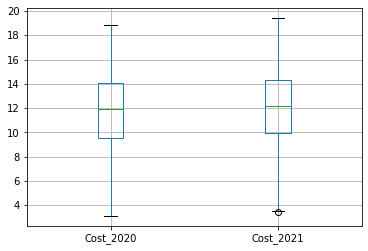

In [65]:
Comparison_Practice_21_22 = Site_Cost[['Cost_2020', 'Cost_2021']].boxplot()

We can see quite a wide variation in per capita spend and limited change in average hovering around the £12 mark

The next chart for 2021 only is a impractical chart for actually reading the practice names but gives an idea of spread as well.  but we do see that there is some variation worth exploring (seperate groups at top and bottom) for PHE. It also crucially from a spend perspective highlights the different levels of need of practices.

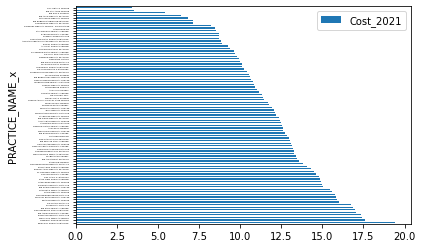

In [66]:
Bar_Site = Site_Cost.plot(kind = 'barh', y= 'Cost_2021', x='PRACTICE_NAME_x').tick_params(axis= 'y' , labelsize = 2)

We do see that there is some variation worth exploring (seperate groups at top and bottom) for PHE. It also crucially from a spend perspective highlights the different levels of need of practices.

## Sites of Intrest for PHE
The next two charts highlight the top and bottom spenders 

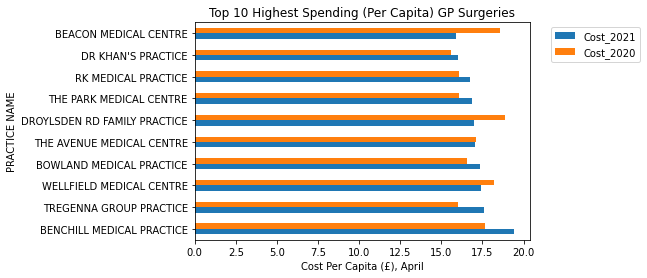

In [67]:
## Top 10

Site_Cost_Top_10 = Site_Cost.nlargest(10, "Cost_2021")

Top_10 = Site_Cost_Top_10[['Cost_2021', 'Cost_2020']].plot.barh()
plt.ylabel('PRACTICE NAME')
plt.xlabel('Cost Per Capita (£), April')
plt.title('Top 10 Highest Spending (Per Capita) GP Surgeries')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

I would suggest that PHE would look at these high spending practices (particuarly those with increases year on year) to help plan stocking and also potentially factor impact into budgeting of any health improvment project they have planned. Equally, this could be just regional variation (age etc.) but likely oppitunties to mitigate health inequalities might impact some of these. 

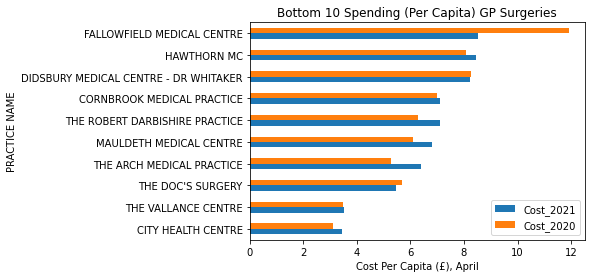

In [68]:
# Bottom 10

Site_Cost_Bottom_10 = Site_Cost.nsmallest(10, "Cost_2021")

Bottom_10 = Site_Cost_Bottom_10[['Cost_2021', 'Cost_2020']].plot.barh()
plt.ylabel('PRACTICE NAME')
plt.xlabel('Cost Per Capita (£), April')
plt.title('Bottom 10 Spending (Per Capita) GP Surgeries')
plt.show()

Similarly these are practices of intrest when budgeting next year. Particuarly of note is Fallowfield Medical Centre which has dropped expenditure considerably but this is likely to be due to a high 2020 (COVID first wave) rather than continued trend as it is the most student dominated medical practice. Might be worth investigating futher.  

The next section looks at the variation rather than the totals

       Actual_Cost_2020  Cost_2020  Actual_Cost_2021  Cost_2021  \
count         85.000000  85.000000         85.000000  85.000000   
mean       88865.179547  11.850550      91747.120462  12.029193   
std        39368.579570   3.305455      40895.032472   3.200868   
min        18049.789020   3.120043      19005.347650   3.437274   
25%        57849.806350   9.507459      61639.863040   9.988564   
50%        88044.327140  11.956393      91269.235510  12.159857   
75%       116318.196650  14.089607     116682.678820  14.330138   
max       190527.060670  18.845562     190169.621640  19.399125   

       Percentage_Change  Percentage_Change_Total  
count          85.000000                85.000000  
mean            2.407316                 3.599467  
std             9.367835                 9.363730  
min           -28.543823               -14.527816  
25%            -3.613998                -2.093695  
50%             3.202806                 3.319912  
75%             6.768971        

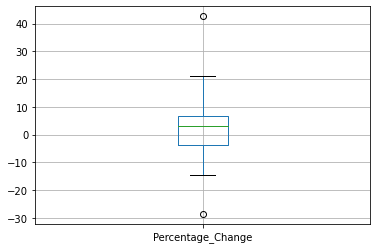

In [69]:
#Change difference

Site_Cost =Site_Cost.sort_values(by = 'Percentage_Change', ascending= False)

Site_Change = Site_Cost.boxplot( column = "Percentage_Change", return_type = 'axes')

print(Site_Cost.describe())

print(Site_Cost.head())

I think its important to look at the percentage change as meaning we can't really predict on a surgery by surgery level to a very specific degree of needs. I think we would need to assess the outliers quite closely as thes are both warning signs (although the lower one for fallowfield is liekly to be seeing 2020 as the blip not vis-versa.

Finally, we can summarise by saying overall expenditure is showing a relatively small growth (3.2%) but the variation by practice is less predicatable (IQR = -3.6, 6.8%) with some practices having considerable variation. 

## Regional Data
First we plot the Cost per Capita of each Postcode District (based on surgery location not patient location) 

       Actual_Cost_2020  Cost_2020  Actual_Cost_2021  Cost_2021  \
count         17.000000  17.000000         17.000000  17.000000   
mean      444325.897735  11.148868     458735.602308  11.395905   
std       212908.261229   3.049283     216958.121214   3.043180   
min        88350.012970   4.076689      89796.390440   4.258781   
25%       234201.027000   9.966159     238274.362020   9.476993   
50%       402330.952740  12.124430     442765.516090  12.288518   
75%       622993.559840  12.954887     626471.822310  13.494134   
max       732820.364910  14.852987     784902.032580  15.619008   

       Percentage_Change  Percentage_Change_Total  
count          17.000000                17.000000  
mean            2.675648                 3.665956  
std             4.615938                 3.509890  
min            -4.908271                -2.430453  
25%            -0.107695                 1.637099  
50%             2.830485                 3.845278  
75%             4.466645        

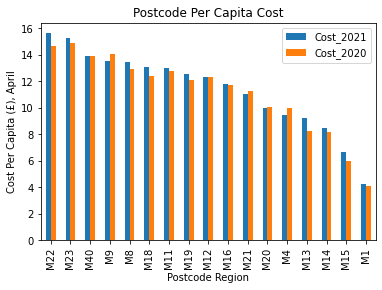

In [70]:
print(Postcode_Cost.describe())

Postcode_Cost =Postcode_Cost.sort_values(by = 'Cost_2021', ascending= False)

Postcode_Cost.set_index("Postcode_Region", drop=False, inplace = True)

Postcode_Bar = Postcode_Cost[['Cost_2021', 'Cost_2020']].plot.bar()
plt.xlabel('Postcode Region')
plt.ylabel('Cost Per Capita (£), April')
plt.title('Postcode Per Capita Cost')
plt.show()

Again we see quite a range of variation with patients in M1 (central manchester having a lot less percription expenditure) then those in Wythenshawe and Gatley M22. Again local comparisons could potentially offer some explanations for this (Age is a clear possible explanation with city centre being the youngest area) but also can relate to depreviation and a myriad of factors. 

## Maps

Below I have created link ID's to postcode dataset and GeoJSon and the created Plotly interactive Choropleths which (if using in JUypter should load in browser (depending on settings) also included in repo. The colours correspond to spend April 2020, April 2021 and % change respectively. 

In [71]:
Manchester_Map['features'][1]['properties']

Postcode_Cost['id']= Postcode_Cost['Postcode_Region']

Postcode_Dictionary = {}

for feature in Manchester_Map['features']:
    feature['id']=feature['properties']['name']
    Postcode_Dictionary[feature['properties']['name']] =feature['id']
    
fig1 = px.choropleth(Postcode_Cost, locations = 'id', geojson= Manchester_Map, color= 'Cost_2021', hover_name='Postcode_Region', title= "Cost Per Capita April 2021" )
fig1.update_geos(fitbounds = "locations", visible= False)
fig1.show()

fig2 = px.choropleth(Postcode_Cost, locations = 'id', geojson= Manchester_Map, color= 'Cost_2020', hover_name='Postcode_Region', title= "Cost Per Capita April 2020" )
fig2.update_geos(fitbounds = "locations", visible= False)
fig2.show()

fig3 = px.choropleth(Postcode_Cost, locations = 'id', geojson= Manchester_Map, color= 'Percentage_Change', hover_name='Postcode_Region', title= "Percentage Change in cost" )
fig3.update_geos(fitbounds = "locations", visible= False)
fig3.show()

We can see the grouping in 2020 map of the high cost areas per capita with the two southern and north east being quite clearly the most extreme and central zones carrying lower expenditure. The change from 2021 in the high values shows the south still carrying a substantial higher cost and this seems to be due marginal decrease in costs for M9 & M40 -3.4% and 0% change respectively and increases for M23 and M22 of 2.8% and 6.6% for year on year. The last obvious zone of change (is although starting below the average expenditure the band below the city centre M15 and M13 are carrying growth of 12.1% & 11.3% respectively and PHE should pay attention to this.

## Total Cost
Repeating the analysis but for total cost rather than per capita

## Exploratory Visuals for GP Practice level Perscription Spend
very quick boxplots to assess difference between costs

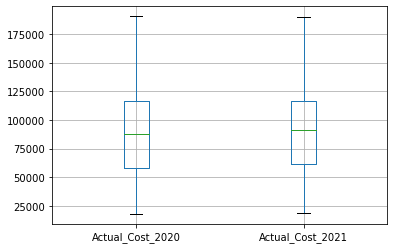

In [72]:
Comparison_Practice_21_22 = Site_Cost[['Actual_Cost_2020', 'Actual_Cost_2021']].boxplot()

The next chart for 2021 could highlight some of the variation we have already seen but could also just highlight the different sizes of surgerys.

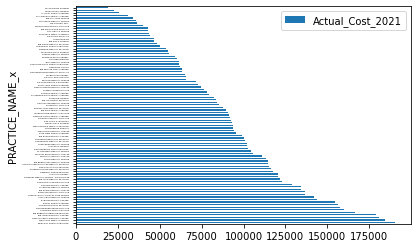

In [73]:
Site_Cost =Site_Cost.sort_values(by = 'Actual_Cost_2021', ascending= False)

Bar_Site = Site_Cost.plot(kind = 'barh', y= 'Actual_Cost_2021', x='PRACTICE_NAME_x').tick_params(axis= 'y' , labelsize = 2)

It does highlight that despite variations in expenditure that clearly demonstrates that budgeting should not put equal weight to all GP practices and that likely impacts of some GPs could be as much as 7 times as high as others. This however begs another question for PHE while these bigger practices might be able to manage demand and even stockpile certain products individual patients at these very small surgeries are likely to need assistance if shortages of certain products arise as they are unlikely to be able to have the flexibility in stock that larger centres do.

## Sites of Intrest
Below are the most important pracitices in terms of scale

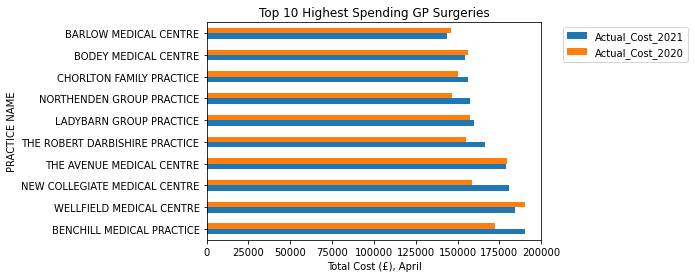

In [74]:
Site_Cost_Top_10 = Site_Cost.nlargest(10, "Actual_Cost_2021")

Top_10 = Site_Cost_Top_10[['Actual_Cost_2021', 'Actual_Cost_2020']].plot.barh()
plt.ylabel('PRACTICE NAME')
plt.xlabel('Total Cost (£), April')
plt.title('Top 10 Highest Spending GP Surgeries')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

I Think the contrast the difference are particuarly intresting in here and should remind PHE that a change in one large Practice can have an impact that can equate to whole new surgery. Also that size does not completly imply stability is an additional finding. 

Below are the smallest perscription expenditure by surgery

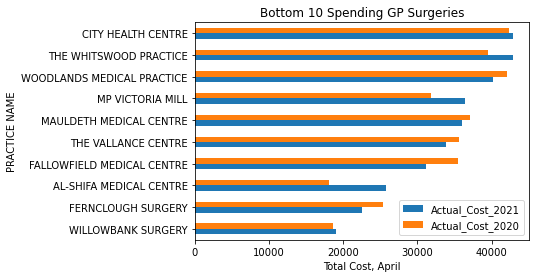

In [75]:
Site_Cost_Bottom_10 = Site_Cost.nsmallest(10, "Actual_Cost_2021")

Bottom_10 = Site_Cost_Bottom_10[['Actual_Cost_2021', 'Actual_Cost_2020']].plot.barh()
plt.ylabel('PRACTICE NAME')
plt.xlabel('Total Cost, April')
plt.title('Bottom 10 Spending GP Surgeries')
plt.show()

Once again Al-Shifa shows a significant change in expenditure from 2020 to 2021

Below we explore the detail of the change and some summary stastics

       Actual_Cost_2020  Cost_2020  Actual_Cost_2021  Cost_2021  \
count         85.000000  85.000000         85.000000  85.000000   
mean       88865.179547  11.850550      91747.120462  12.029193   
std        39368.579570   3.305455      40895.032472   3.200868   
min        18049.789020   3.120043      19005.347650   3.437274   
25%        57849.806350   9.507459      61639.863040   9.988564   
50%        88044.327140  11.956393      91269.235510  12.159857   
75%       116318.196650  14.089607     116682.678820  14.330138   
max       190527.060670  18.845562     190169.621640  19.399125   

       Percentage_Change  Percentage_Change_Total  
count          85.000000                85.000000  
mean            2.407316                 3.599467  
std             9.367835                 9.363730  
min           -28.543823               -14.527816  
25%            -3.613998                -2.093695  
50%             3.202806                 3.319912  
75%             6.768971        

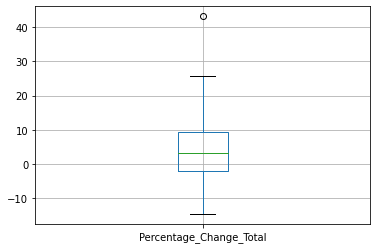

In [76]:
Site_Cost =Site_Cost.sort_values(by = 'Percentage_Change_Total', ascending= False)

Site_Change = Site_Cost.boxplot( column = "Percentage_Change_Total", return_type = 'axes')

print(Site_Cost.describe())

print(Site_Cost.head())

We can see that total change is higher than per capita change. THis would be expected as manchester has a increasing population. Also the IQR is wider which as practice numbers change is expected but one of the clear outliers drops off (this might be a lag in patients removing adding the practice so wasn't really correct data to begin with)

## Regional Data

below is bar chart indicating the difference in total expendenture between each postcode. 

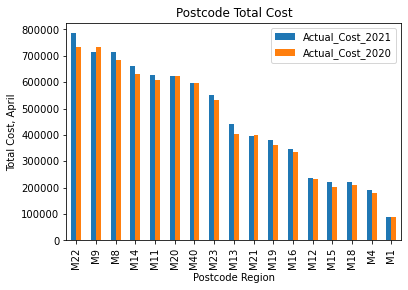

In [79]:
Postcode_Cost =Postcode_Cost.sort_values(by = 'Actual_Cost_2021', ascending= False)

Postcode_Cost.set_index("Postcode_Region", drop=False, inplace = True)

Postcode_Bar = Postcode_Cost[['Actual_Cost_2021', 'Actual_Cost_2020']].plot.bar()
plt.xlabel('Postcode Region')
plt.ylabel('Total Cost, April')
plt.title('Postcode Total Cost')
plt.show()

As you can see it changes quite a few of the 'rankings' as M23 was the secondest highest contributor per in April 2021 but 8th in total becuase of a smaller population. I think we have to be careful in reading any of the following maps for this reason (possibly excluding % change) becuase it visually implies a geographical difference which is made up of both population and cost per person and from a PHE viewpoint it would not use postcode anyway so would seem quite arbitary to show this information in map form. 

## Maps

In [81]:
fig1 = px.choropleth(Postcode_Cost, locations = 'id', geojson= Manchester_Map, color= 'Actual_Cost_2021', hover_name='Postcode_Region', title= "Total Cost April 2021" )
fig1.update_geos(fitbounds = "locations", visible= False)
fig1.show()

fig2 = px.choropleth(Postcode_Cost, locations = 'id', geojson= Manchester_Map, color= 'Actual_Cost_2020', hover_name='Postcode_Region', title= "Total Cost April 2020" )
fig2.update_geos(fitbounds = "locations", visible= False)
fig2.show()

fig3 = px.choropleth(Postcode_Cost, locations = 'id', geojson= Manchester_Map, color= 'Percentage_Change_Total', hover_name='Postcode_Region', title= "Total percentage Change" )
fig3.update_geos(fitbounds = "locations", visible= False)
fig3.show()

As you can see this implies that M20 is a high cost postcode district but actually from a PHE management of perscriptions perspective it would not count as such becuase the oppitunity and cost comes from its population not from its expendeture per person.